<a href="https://colab.research.google.com/github/muharremyasar/PROJECTSm/blob/main/btc_historical_with_rnn_and_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  BTC historical with RNN and Deployment

In [162]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = (11,3)
sns.set_style("whitegrid")
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model    #  to pickle DL large files
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import itertools
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle, joblib



In [163]:
# CODE SECTION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
def evals_():
    print("y_train / y_train_pred ")
    eval_metrics(y_train, y_train_pred)
    print("y_test / y_test_pred ")
    eval_metrics(y_test, y_test_pred)

# Visualising the results
def ploty(real,predicted)  :
    plt.plot(real,      color = 'red' , label = '  Real Price'     )   # Real Stock price
    plt.plot(predicted, color = 'blue', label = '  Predicted Price')
    plt.xlabel('Day') ; plt.ylabel(' Price') ; plt.legend()
    plt.show()
def plot_():
    ploty(y_train,y_train_pred)    # TRAIN
    ploty(y_test,y_test_pred)       # TEST
    
def shape_():
    print("X_train shape:",X_train.shape, "\nX_test shape:",X_test.shape)
    print("y_train shape:",y_train.shape, "\ny_test shape:",y_test.shape)

In [164]:
data = pd.read_csv("/content/btc historical data set/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [165]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.4,4.4,4.4,4.4,0.5,2.0,4.4
1,1325317980,nan,nan,nan,nan,nan,nan,nan
2,1325318040,nan,nan,nan,nan,nan,nan,nan
3,1325318100,nan,nan,nan,nan,nan,nan,nan
4,1325318160,nan,nan,nan,nan,nan,nan,nan


#### There are many NaN values

In [166]:
data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.3,58714.3,58686.0,58686.0,1.4,81259.4,58692.8
4857373,1617148620,58684.0,58693.4,58684.0,58685.8,7.3,428158.1,58693.2
4857374,1617148680,58693.4,58723.8,58693.4,58723.8,1.7,100117.1,58696.2
4857375,1617148740,58742.2,58770.4,58742.2,58760.6,0.7,42333.0,58761.9
4857376,1617148800,58767.8,58778.2,58756.0,58778.2,2.7,159417.8,58764.3


## Explanation of the features

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


<div>

<p>   Timestamp - This is the unix timestamp   Day and Time recorded together in a series
<p>   Open - This is the opening price of the time period
<p>   High - This is the highest price of the time period
<p>   Low - This is the lowest price of the time period
<p>   Close - This is the closing price of the time period
<p>   Volume (BTC) - This is the volume in BTC
<p>   Volume (Curency) - This is the volume in USDT amount
<p>   Weighted_Price - This is the weighted price of BTC in USDT

</div>


In [168]:
# Converting Timestamp value to Date-Time (yy/mm/dd hh:mm:ss)

data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.head(4)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.4,4.4,4.4,4.4,0.5,2.0,4.4
1,2011-12-31 07:53:00,nan,nan,nan,nan,nan,nan,nan
2,2011-12-31 07:54:00,nan,nan,nan,nan,nan,nan,nan
3,2011-12-31 07:55:00,nan,nan,nan,nan,nan,nan,nan


#### It is seen that records are in minutes

In [169]:
data.shape

(4857377, 8)

#### There are 4.8 million records. They are too much to evaluate, it can take days
####  So lets decrease it by summing the minutes into day

In [170]:
# Make a new column which has only Date value of timestamp
data['Date'] = data['Timestamp'].dt.date
data.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,2011-12-31 07:52:00,4.4,4.4,4.4,4.4,0.5,2.0,4.4,2011-12-31
1,2011-12-31 07:53:00,nan,nan,nan,nan,nan,nan,nan,2011-12-31


In [171]:
data_day=data.groupby("Date").mean()    # it takes the mean of the dataset 
data_day.head(2)                      # now the columns are   in daily

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,
2011-12-31,4.5,4.5,4.5,4.5,23.8,106.3,4.5
2012-01-01,4.8,4.8,4.8,4.8,7.2,35.3,4.8


In [172]:
data_day.tail(2)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,
2021-03-30,58347.8,58372.0,58324.0,58349.4,2.4,138231.2,58346.9
2021-03-31,58767.8,58778.2,58756.0,58778.2,2.7,159417.8,58764.3


In [173]:
len(data_day)

3376

The number of records now more practical

In [174]:
data.corr()*100

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,100.0,100.0,100.0,100.0,-5.2,34.4,100.0
High,100.0,100.0,100.0,100.0,-5.2,34.4,100.0
Low,100.0,100.0,100.0,100.0,-5.2,34.4,100.0
Close,100.0,100.0,100.0,100.0,-5.2,34.4,100.0
Volume_(BTC),-5.2,-5.2,-5.2,-5.2,100.0,35.2,-5.2
Volume_(Currency),34.4,34.4,34.4,34.4,35.2,100.0,34.4
Weighted_Price,100.0,100.0,100.0,100.0,-5.2,34.4,100.0


In [175]:
data_day.corr()*100

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,100.0,100.0,100.0,100.0,-21.7,76.7,100.0
High,100.0,100.0,100.0,100.0,-21.7,76.7,100.0
Low,100.0,100.0,100.0,100.0,-21.7,76.7,100.0
Close,100.0,100.0,100.0,100.0,-21.7,76.7,100.0
Volume_(BTC),-21.7,-21.7,-21.7,-21.7,100.0,1.7,-21.7
Volume_(Currency),76.7,76.7,76.7,76.7,1.7,100.0,76.7
Weighted_Price,100.0,100.0,100.0,100.0,-21.7,76.7,100.0


data_day correlation increased !

In [176]:
# Rename the column names to getrid off () paranthesis

data_day.rename(columns={'Volume_(BTC)': 'Volume_BTC', 'Volume_(Currency)': 'Volume_Currency'}, inplace=True)

In [177]:
fn=list(data_day.columns)
fn

['Open',
 'High',
 'Low',
 'Close',
 'Volume_BTC',
 'Volume_Currency',
 'Weighted_Price']

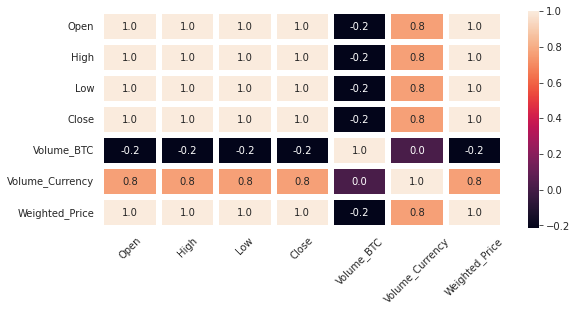

In [178]:
f,ax = plt.subplots(figsize=(9, 4))
sns.heatmap(data_day.corr(), annot=True, linewidths=5, fmt= '.1f',ax=ax)
plt.xticks(rotation= 45) 
plt.show()

#### Weighted_Price has a full relation with Open, High and Low

#### We only will use Weighted_Price column  
(any of the high correlation feautures as Open, High, Low, Close can be used)

In [179]:
df=data_day.Weighted_Price
df

Date
2011-12-31       4.5
2012-01-01       4.8
2012-01-02       5.0
2012-01-03       5.3
2012-01-04       5.2
               ...  
2021-03-27   55193.4
2021-03-28   55833.0
2021-03-29   56914.0
2021-03-30   58346.9
2021-03-31   58764.3
Name: Weighted_Price, Length: 3376, dtype: float64

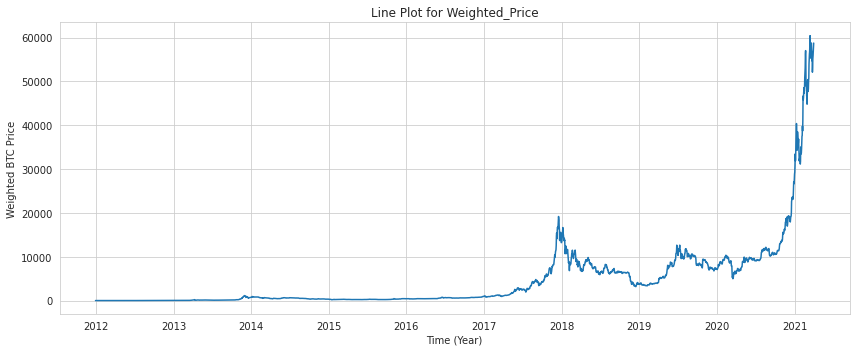

In [180]:
# Line Plot
plt.figure(figsize=(12, 5))
df.plot( grid=True) # color = "b",kind = "line",  linewidth=1,  alpha=1,linestyle=":"
plt.xlabel("Time (Year)")            # label = name of the x axis
plt.ylabel("Weighted BTC Price")            # label = name of the y axis
plt.title("Line Plot for Weighted_Price")          # title = Title of the Plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Weighted_Price vs Volume_Currency Scatter Plot')

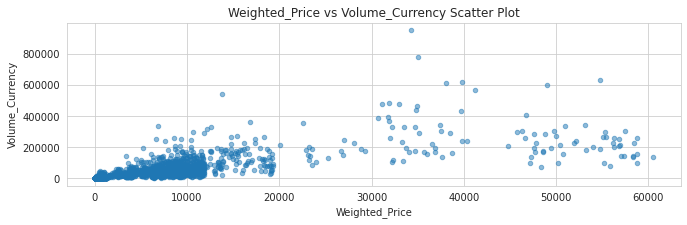

In [181]:
# Scatter Plot
data_day.plot(kind="scatter", x="Weighted_Price", y="Volume_Currency", alpha=0.5 )
plt.xlabel("Weighted_Price")
plt.ylabel("Volume_Currency")
plt.title("Weighted_Price vs Volume_Currency Scatter Plot")
#plt.show()

## Visulazations


In [182]:
#sns.pairplot(data_day)

Text(0.5, 1.0, 'Weighted_Price vs Volume_Currency Scatter Plot')

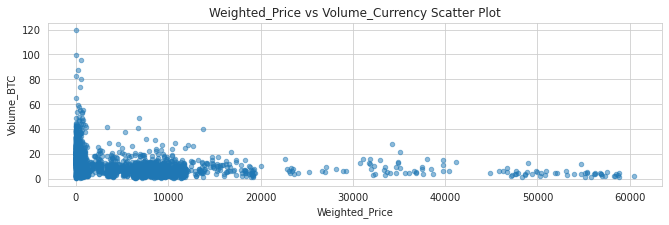

In [183]:
# Scatter Plot
data_day.plot(kind="scatter", x="Weighted_Price", y="Volume_BTC", alpha=0.5 )
plt.xlabel("Weighted_Price")
plt.ylabel("Volume_BTC")
plt.title("Weighted_Price vs Volume_Currency Scatter Plot")
#plt.show()

#### inverse proportion between VolumeBTC and Price.  When price increase, volume decrease.

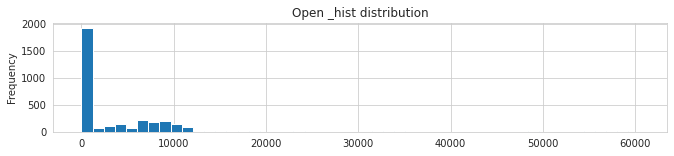

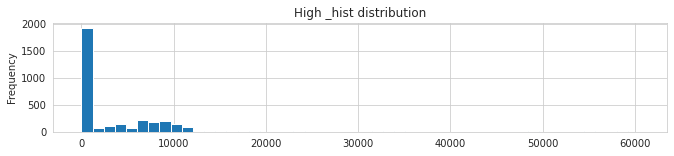

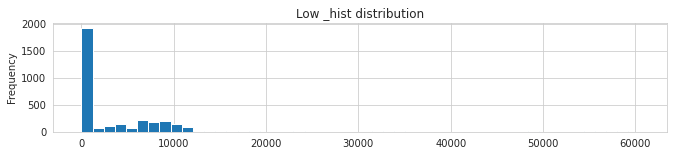

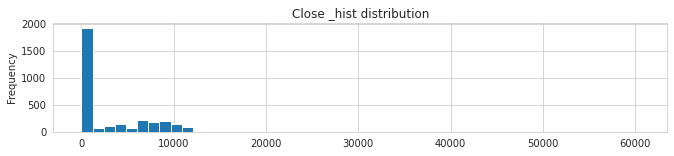

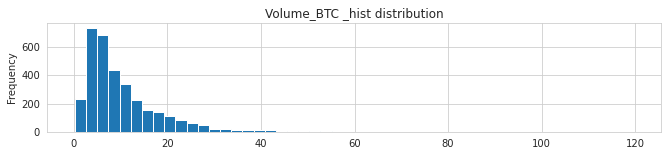

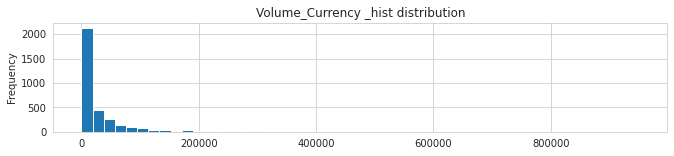

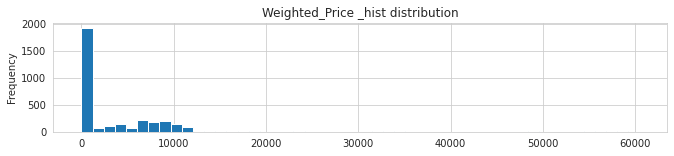

In [184]:
for h in fn: # fn: feautere names
    plt.figure(figsize=(11,2))
    plt.hist( data_day[h],bins = 50) ; plt.ylabel("Frequency") 
    plt.title("{} _hist distribution".format(h))
    plt.show()

There are many ZERO or near ZERO records even in Weighted_Price 

In [185]:
data_day.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3376.0,4605.6,8207.3,4.3,245.0,698.0,7242.7,60458.3
High,3376.0,4608.9,8213.8,4.3,245.0,698.2,7248.2,60488.9
Low,3376.0,4602.2,8200.6,4.3,244.9,697.7,7238.0,60426.4
Close,3376.0,4605.6,8207.4,4.3,245.0,697.9,7242.4,60458.9
Volume_BTC,3376.0,10.4,8.9,0.2,4.7,7.6,13.1,119.5
Volume_Currency,3376.0,31790.8,62754.0,1.2,1916.2,6832.0,36074.5,950995.6
Weighted_Price,3376.0,4605.6,8207.0,4.3,245.0,697.9,7242.9,60455.8


#### There are No ZERO values in Weihted_Price feuture as it is seen above.
Then it can show that there maybe  NaN values Let's check.

## EDA

In [186]:
data_day.isnull().sum()  # Get the number of missing data in each feauture

Open               0
High               0
Low                0
Close              0
Volume_BTC         0
Volume_Currency    0
Weighted_Price     0
dtype: int64

In [187]:
data_day.isnull().sum().sum()  # Get the number of missing data in each feauture

0

There is no NaN values ( all disappered when merging minutes into day )
#### It means that all these are " nearest to the Zero" values are because of they are very small values.
(for a long time from BTC's early days it has been very low priced)



In [188]:
data_last=data_day[int(len(data_day)*0.66):]  # The last 1/3 part of the dataset
len(data_last)

1148

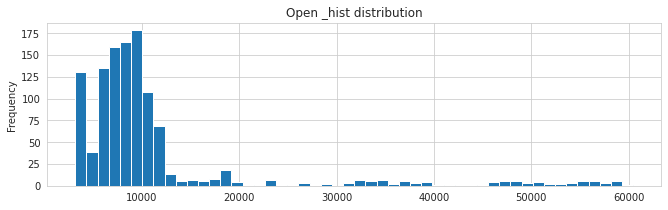

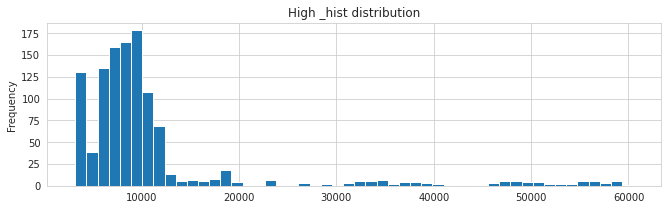

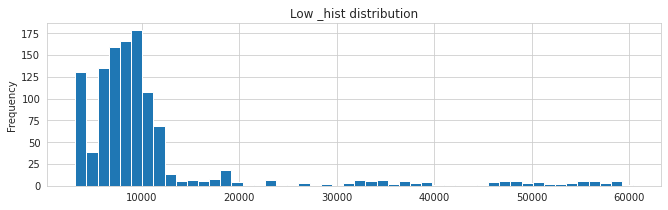

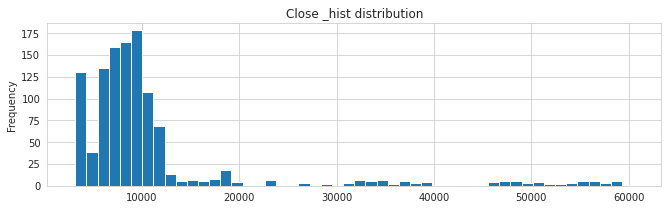

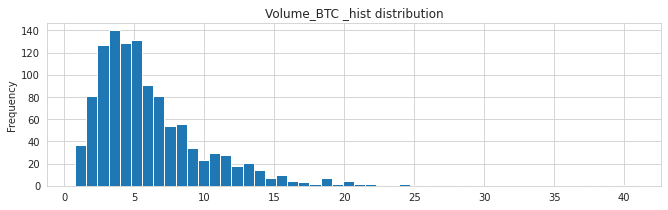

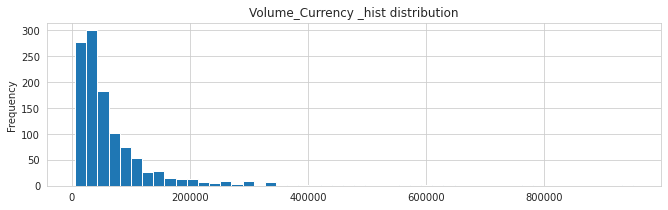

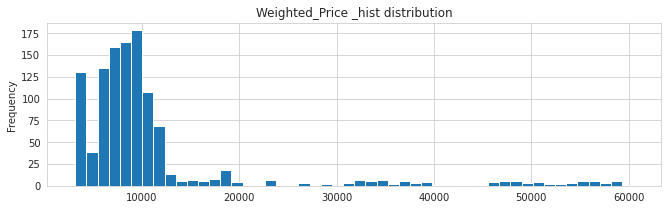

In [189]:
for h in fn: # fn: feautere names
    plt.hist( data_last[h],bins = 50) ; plt.ylabel("Frequency") 
    plt.title("{} _hist distribution".format(h))
    plt.show()

# RNN:Recurrent Neural Network

## Prepare Data for RNN

In [190]:
#df=df.values

In [191]:
# Defining the  TRAIN and TEST part of the dataset

test_days=30   
train=df[:-test_days]               # the days before the last 30 days
test=df[len(df)-test_days:]         # the last 30 days

In [192]:
print("Train length:",len(train), "\nTest length:",len(test))

Train length: 3346 
Test length: 30


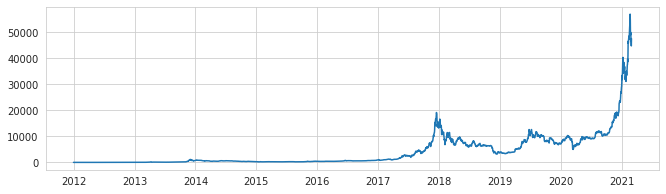

In [193]:
plt.plot(train)
plt.show()

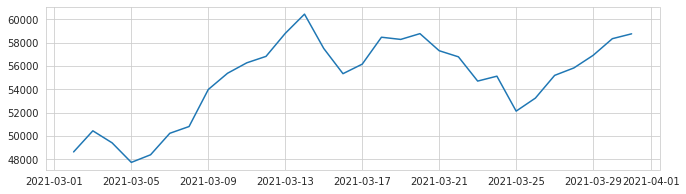

In [194]:
plt.plot(test)
plt.show()

In [195]:
df=pd.DataFrame(data_day.Weighted_Price)
df.shape

(3376, 1)

In [196]:
#df=np.array(data_day.Weighted_Price).reshape(-1,1)
#df.shape

In [197]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_s = scaler.fit_transform(df)     # df_s : df_scaled
 


In [198]:
print("Max:",df_s.max(),"\tMin:",df_s.min())

Max: 0.9999999999999999 	Min: 0.0


##  using only 10 sequential days

In [199]:
# Creating a data structure with 10 timesteps and 1 output

df_X, df_y = [],[]
first=10           #  first array=  time steps
last =len(df_s)   # last array
for i in range(first,last):
    df_X.append(df_s[i-first:i])
    df_y.append(df_s[i])

In [200]:
df_X, df_y = np.array(df_X), np.array(df_y) 

In [201]:
# Defining the  TRAIN and TEST part of the dataset
test_days=30   
X_train=df_X[:-test_days]               # the days before the last 30 days
y_train=df_y[:-test_days]
X_test=df_X[len(df_X)-test_days:]         # the last 30 days
y_test=df_y[len(df_X)-test_days:] 

shape_()

X_train shape: (3336, 10, 1) 
X_test shape: (30, 10, 1)
y_train shape: (3336, 1) 
y_test shape: (30, 1)


In [202]:
### Create RNN Model

# Initialising the RNN
regressor = Sequential()
# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 10,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))    # units: 30
regressor.add(Dropout(0.2))
# Adding a second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 10,activation='relu', return_sequences = True))
#regressor.add(Dropout(0.2))
# Adding a third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 2,activation='tanh', return_sequences = True))
#regressor.add(Dropout(0.2))
# Adding a fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 20))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))
regressor.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 10, 10)            120       
                                                                 
 dropout_8 (Dropout)         (None, 10, 10)            0         
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 10, 10)            210       
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 10, 2)             26        
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 20)                460       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Epoch 1/30
223/223 [==============================] - 5s 10ms/step - loss: 0.0052
Epoch 2/30
223/223 [==============================] - 2s 10ms/step - loss: 0.0021
Epoch 3/30
223/223 [==============================] - 2s 10ms/step - loss: 0.0013
Epoch 4/30
223/223 [==============================] - 2s 10ms/step - loss: 0.0014
Epoch 5/30
223/223 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 6/30
223/223 [==============================] - 2s 10ms/step - loss: 8.3854e-04
Epoch 7/30
223/223 [==============================] - 2s 10ms/step - loss: 8.6266e-04
Epoch 8/30
223/223 [==============================] - 2s 9ms/step - loss: 6.9682e-04
Epoch 9/30
223/223 [==============================] - 2s 10ms/step - loss: 7.6876e-04
Epoch 10/30
223/223 [==============================] - 2s 10ms/step - loss: 6.0635e-04
Epoch 11/30
223/223 [==============================] - 2s 10ms/step - loss: 4.9699e-04
Epoch 12/30
223/223 [==============================] - 2s 10ms/step - los

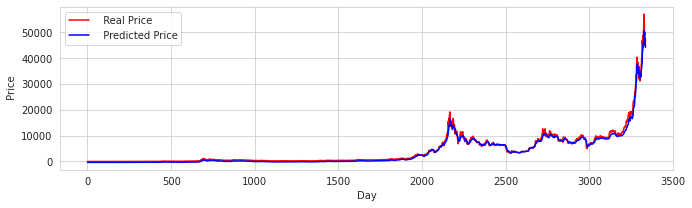

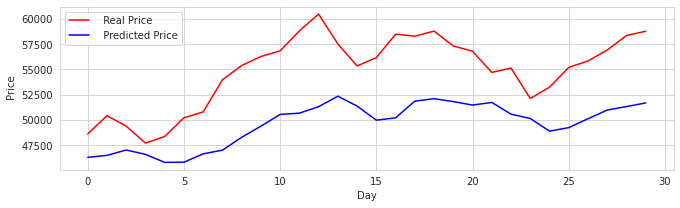

In [203]:

epochs, batch_size = 30,15
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

# save the model to disk
#joblib.dump(regressor, "RNN_model.sav")
# pickle.dump(regressor, open("RNN_model.sav", 'wb'))
regressor.save("RNN_model.h5")  # creates a HDF5 file for saving the model
joblib.dump(scaler,"RNN_scaler")
joblib.dump(df,"RNN_df")

## Prediction wih RNN Model
y_train_pred = regressor.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred= regressor.predict(X_test)        #  predicted_stock_price
y_test_pred =scaler.inverse_transform(y_test_pred)

y_train= scaler.inverse_transform(y_train)
y_test= scaler.inverse_transform(y_test)
plot_()

### 10 sequential days

In [204]:
y_test_pred[-1]

array([51684.582], dtype=float32)

In [205]:
X_train.shape

(3336, 10, 1)

In [206]:
evals_()

y_train / y_train_pred 
------------------------------------
R2_score 	: 0.9864672000590169
MAE 		: 511.5159202784584
MSE 		: 609693.8801140011
RMSE 		: 780.828969822458
y_test / y_test_pred 
------------------------------------
R2_score 	: -1.5400717438189502
MAE 		: 5272.829685667431
MSE 		: 31752879.028333556
RMSE 		: 5634.969301454406


# Deployment Test Section

In [207]:
# some time later...
 
# load the model from disk
regressor=load_model('RNN_model.h5')
    #regressor = pickle.load(open('RNN_model.sav', 'rb'))
    #regressor = joblib.load('RNN_model.sav')
scaler=joblib.load("RNN_scaler")
df=joblib.load("RNN_df")
df_s = scaler.fit_transform(df)     # df_s : df_scale
X_test=np.array([df_s[-10: ]])   
y_test_pred= regressor.predict(X_test)        #  predicted_stock_price
result =scaler.inverse_transform(y_test_pred)


In [208]:
result[0,0]

52256.34